In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import numpy as np
import datetime
import os
from omegaconf import OmegaConf, DictConfig, ListConfig

import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from sklearn.metrics.pairwise import haversine_distances

from geopy.distance import great_circle

from shapely.geometry import MultiPoint

from tqdm import tqdm


from hydra import initialize, compose
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="..\\scripts\\config\\"):
    cfg = compose(config_name='config.yaml')

HW CLASSIFICATION

In [778]:
launch_time = "2023-05-13_15-49-08"
cluster_data = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\clusters_{launch_time}.csv")
df = pd.read_csv(f"H:\\jupyter\\CityTraffic\\data\\{launch_time}\\data_with_clusters_{launch_time}.csv", index_col=0)


In [779]:
cluster_data.head()

id      lat      lon  cluster  cluster_size
0  2.0  54.8436  38.1929      0.0        5056.0
1  6.0  54.9034  38.0696      0.0         989.0
2  6.0  54.8933  38.0780      1.0         830.0
3  8.0  54.8914  38.0634      0.0         569.0
4  8.0  54.8811  38.0551      1.0         241.0

In [780]:
df.head()

lat      lon            ts   id  length  cluster    log_date
0  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21
1  54.8435  38.1928  1.676952e+09  2.0     0.5        0  2023-02-21
2  54.8435  38.1928  1.674846e+09  2.0  1005.0        0  2023-01-27
3  54.8435  38.1928  1.674848e+09  2.0  1005.0        0  2023-01-27
4  54.8435  38.1928  1.674849e+09  2.0  1005.0        0  2023-01-27

In [781]:
#only weekday
def sec_from_day_start(x):
    hm = pd.to_datetime(x, unit='s').dt.strftime('%H:%M:%S').str.split(':')
    return hm.apply(lambda x: 3600 * int(x[0]) + 60 * int(x[1]) + int(x[0]))

THRESH_VALUE = cfg.inq_thresh
SEC_IN_DAY = 60 * 60 * 24
A = 20000
B = 60000
DAY_NIGHT_THRESH = 0.33
if 'work_place' in cluster_data.columns:
    cluster_data.drop(columns=['work_place'], inplace=True)
    
cluster_data['inq'] = None
cluster_data['wewd_ratio'] = None

for cur_id in tqdm(df['id'].unique()):
    cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
    cur_id_clusters = cur_id_df['cluster'].unique()

    #weekdays
    wd_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5].copy()
    cur_id_df['day_ts'] = cur_id_df['ts'] % (SEC_IN_DAY)
    wd_data['day_ts'] = wd_data['ts'] % (SEC_IN_DAY)
    df_gd = cur_id_df.groupby('cluster')
    daytime = df_gd['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])
    day_clusters = daytime[daytime > DAY_NIGHT_THRESH].index
    night_clusters = daytime[daytime <= DAY_NIGHT_THRESH].index

    #day clusters
    day_gd = wd_data[wd_data['cluster'].isin(day_clusters)].groupby('cluster')
    d_inq = day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    day_features = pd.DataFrame({'cluster' : day_clusters})
    day_features = day_features.merge(d_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')


    #night clusters
    night_data = wd_data[~wd_data['cluster'].isin(day_clusters)]
    n_mask = night_data['day_ts'] < night_data['day_ts'].mean()
    night_data.loc[n_mask, 'day_ts'] = SEC_IN_DAY + night_data['day_ts'][n_mask] 
    night_gd = night_data.groupby('cluster')
    n_inq = night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    night_features = pd.DataFrame({'cluster' : night_clusters})
    night_features = night_features.merge(n_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')

    features = pd.concat([day_features, night_features])


    #weekends
    we_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek >= 5].copy()
    ratio = (we_data.groupby('cluster')['log_date'].nunique() / wd_data.groupby('cluster')['log_date'].nunique()) * 2.5
    features['wewd_ratio'] = ratio.fillna(0).values
    features.dropna(inplace=True)
    mask = cluster_data['id'] == cur_id
    cluster_data.loc[mask] = cluster_data.loc[mask].drop(columns=['inq', 'wewd_ratio']).merge(features, on='cluster', how='left').values
cluster_data.dropna(inplace=True)

100%|██████████| 4158/4158 [08:40<00:00,  7.99it/s]


    cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
    cur_id_clusters = cur_id_df['cluster'].unique()


    A = 20000
    B = 60000
    DAY_NIGHT_THRESH = 0.5

    #day night
    # dn_data = cur_id_df[(cur_id_df['cluster'] != -1)].copy()
    # dn_data['day_ts'] = dn_data['ts'] % (SEC_IN_DAY)



    #weekdays
    wd_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5].copy()
    cur_id_df['day_ts'] = cur_id_df['ts'] % (SEC_IN_DAY)
    wd_data['day_ts'] = wd_data['ts'] % (SEC_IN_DAY)
    df_gd = cur_id_df.groupby('cluster')
    daytime = df_gd['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])
    day_clusters = daytime[daytime > DAY_NIGHT_THRESH].index
    night_clusters = daytime[daytime <= DAY_NIGHT_THRESH].index

    #day clusters
    day_gd = wd_data[wd_data['cluster'].isin(day_clusters)].groupby('cluster')
    d_inq = day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - day_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    day_features = pd.DataFrame({'cluster' : day_clusters})
    day_features = day_features.merge(d_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')


    #night clusters
    night_data = wd_data[~wd_data['cluster'].isin(day_clusters)]
    n_mask = night_data['day_ts'] < night_data['day_ts'].mean()
    night_data.loc[n_mask, 'day_ts'] = SEC_IN_DAY + night_data['day_ts'][n_mask] 
    night_gd = night_data.groupby('cluster')
    n_inq = night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.75)) - night_gd[['day_ts']].agg(lambda x: np.quantile(x, 0.25))
    night_features = pd.DataFrame({'cluster' : night_clusters})
    night_features = night_features.merge(n_inq['day_ts'].rename('inq').reset_index(), on='cluster', how='left')

    features = pd.concat([day_features, night_features])


    #weekends
    we_data = cur_id_df[pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek >= 5].copy()
    ratio = (we_data.groupby('cluster')['log_date'].nunique() / wd_data.groupby('cluster')['log_date'].nunique()) * 2.5
    features['wewd_ratio'] = ratio.fillna(0).values
    features.dropna(inplace=True)
    mask = cluster_data['id'] == cur_id
    cluster_data.loc[mask] = cluster_data.loc[mask].drop(columns=['inq', 'wewd_ratio']).merge(features, on='cluster', how='left').values

In [782]:
cluster_data['work_place'] = (cluster_data['inq'] < 28500) & (cluster_data['inq'] > 14000) | (cluster_data['inq'] > 40000) & (cluster_data['inq'] < 45000)

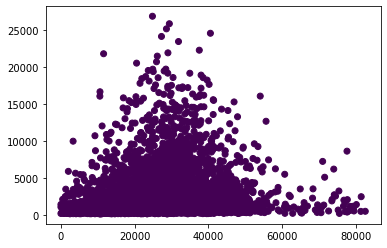

In [900]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X_train = cluster_data[['inq', 'cluster_size']].values
pipe = Pipeline([('scaler', StandardScaler()), ('db', DBSCAN(eps=1))])
pipe.fit(X_train)
cluster_data['class'] = pipe['db'].labels_
plt.scatter(cluster_data['inq'],	cluster_data['cluster_size'], c=pipe['db'].labels_);

In [784]:
cluster_data

id      lat      lon  cluster  cluster_size           inq   
0         2.0  54.8436  38.1929      0.0        5056.0  26032.644737  \
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414   
3         8.0  54.8914  38.0634      0.0         569.0      12856.75   
4         8.0  54.8811  38.0551      1.0         241.0  12940.543478   
...       ...      ...      ...      ...           ...           ...   
5397  50558.0  54.8424  38.1937      0.0         755.0    23004.2539   
5398  50558.0  54.8504  38.1727      1.0         686.0  37051.639583   
5399  50617.0  54.8935  38.0661      0.0         537.0  29144.517724   
5400  50913.0  54.8860  38.0905      0.0         518.0  33435.191521   
5401  52006.0  54.8855  38.0870      0.0         836.0  39378.040404   

     wewd_ratio  work_place  class  
0      1.111111        True      0  
1           0.0        True      0  
2      0.208333       False      0  
3           0.0       False      0  
4           0.0       False      0  
...         ...         ...    ...  
5397        0.0        True      0  
5398   1.666667       False      0  
5399      0.625       False      0  
5400      0.625       False      0  
5401       1.25       False      0  

[5370 rows x 9 columns]

<AxesSubplot: >

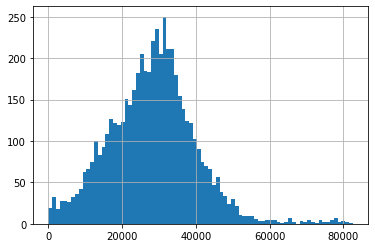

In [785]:
cluster_data['inq'].hist(bins=80)

In [786]:
cluster_data['work_place'].value_counts()

work_place
False    2948
True     2422
Name: count, dtype: int64

In [952]:
filtered_clusters = cluster_data[cluster_data['inq'].between(14000, 53000)]
filtered_clusters = filtered_clusters[]

In [975]:
filtered_clusters

id      lat      lon  cluster  cluster_size           inq   
0         2.0  54.8436  38.1929      0.0        5056.0  26032.644737  \
1         6.0  54.9034  38.0696      0.0         989.0  15146.533333   
2         6.0  54.8933  38.0780      1.0         830.0  39723.665414   
5        13.0  54.8428  38.1908      0.0        2908.0  38369.617647   
6        14.0  54.8419  38.1885      0.0        2213.0   35349.09434   
...       ...      ...      ...      ...           ...           ...   
5397  50558.0  54.8424  38.1937      0.0         755.0    23004.2539   
5398  50558.0  54.8504  38.1727      1.0         686.0  37051.639583   
5399  50617.0  54.8935  38.0661      0.0         537.0  29144.517724   
5400  50913.0  54.8860  38.0905      0.0         518.0  33435.191521   
5401  52006.0  54.8855  38.0870      0.0         836.0  39378.040404   

     wewd_ratio  work_place  class  
0      1.111111        True      0  
1           0.0        True      0  
2      0.208333       False      0  
5      1.071429       False      0  
6      0.833333       False      0  
...         ...         ...    ...  
5397        0.0        True      0  
5398   1.666667       False      0  
5399      0.625       False      0  
5400      0.625       False      0  
5401       1.25       False      0  

[4650 rows x 9 columns]

<AxesSubplot: >

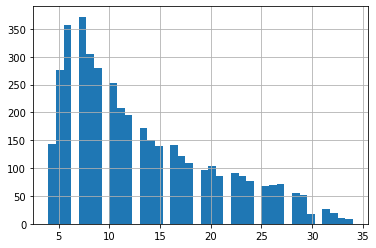

In [979]:
df.groupby('id')['log_date'].nunique().hist(bins=40)

In [953]:
filtered_clusters['work_place'].value_counts()

work_place
True     2422
False    2228
Name: count, dtype: int64

In [954]:
geometry = [Point(xy) for xy in zip(filtered_clusters['lon'], filtered_clusters['lat'])]
gdf = gpd.GeoDataFrame(filtered_clusters, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [971]:
cur_id = 3451
cur_id_df = df.query('id == @cur_id and cluster != -1').copy()
data = cur_id_df[(pd.to_datetime(cur_id_df['ts'], unit='s').dt.dayofweek < 5)].copy()
data['day_ts'] = cur_id_df['ts'] % (60 * 60 * 24)
cur_cluster_data = cluster_data[cluster_data['id'] == cur_id]
cur_cluster_data

id      lat      lon  cluster  cluster_size           inq   
1400  3451.0  54.9389  38.0166      0.0         932.0  32120.742697  \
1401  3451.0  54.8949  38.0816      1.0        3063.0  20628.051214   

     wewd_ratio  work_place  class  
1400        1.0       False      0  
1401        0.0        True      0

In [960]:
data.groupby('cluster')['day_ts'].apply(lambda x: np.sum(x.between(A, B)) / x.shape[0])

cluster
0    0.143777
1    0.673957
Name: day_ts, dtype: float64

In [969]:
for cluster in data['cluster'].unique():
    print(cluster, data.groupby(['cluster', 'log_date'])[['length']].sum().stack()[cluster].median())

0 26050.0
1 22068.0


In [970]:
data.groupby(['cluster', 'log_date'])[['length']].sum().stack()

cluster  log_date          
0        2023-02-21  length     1386.0
         2023-02-22  length    26050.0
         2023-02-23  length    31274.0
1        2023-02-08  length     1923.0
         2023-02-09  length    25849.0
         2023-02-21  length        1.0
         2023-02-27  length    22068.0
         2023-02-28  length    36858.0
dtype: float64

(0.0, 80000.0)

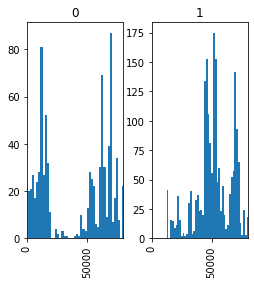

In [962]:
ax_list = data['day_ts'].hist(layout=(1,3), by=data['cluster'], bins=48)
ax_list[0].set_xlim((0, 80000))
ax_list[1].set_xlim((0, 80000))
ax_list[2].set_xlim((0, 80000))


In [963]:
cur_id_df.groupby('cluster')['log_date'].nunique()

cluster
0    3
1    7
Name: log_date, dtype: int64

In [964]:
cur_id_df['log_date'].nunique()

9

In [965]:
geometry = [Point(xy) for xy in zip(cur_cluster_data['lon'],cur_cluster_data['lat'])]
gdf = gpd.GeoDataFrame(cur_cluster_data , geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='work_place', cmap=['blue', 'green', 'red', 'orange'])

In [966]:
geometry = [Point(xy) for xy in zip(cur_id_df['lon'], cur_id_df['lat'])]
gdf = gpd.GeoDataFrame(cur_id_df, geometry=geometry, crs=4326)
gdf.explore(categorical=True, column='cluster', cmap=['blue', 'green', 'red', 'orange'])